# Transferir aprendizagem/ajuste
---

Este tutorial irá guiá-lo através do processo de uso de _aprendizado por transferência_ para aprender um classificador de imagem preciso a partir de um número relativamente pequeno de amostras de treinamento. De modo geral, a aprendizagem por transferência refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão dessa rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser pequeno demais para ser treinado para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender recursos de imagem geralmente aprendem recursos semelhantes de qualquer maneira, especialmente nas camadas iniciais, onde são mais genéricas (detectores de borda, bolhas, e assim por diante).

A aprendizagem por transferência foi amplamente possibilitada pelo código aberto de modelos de última geração; para os modelos de melhor desempenho em tarefas de classificação de imagens (como em [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo também. Isso permite que amadores usem esses classificadores de imagens de ponta para aumentar o desempenho de seus próprios modelos específicos de tarefas.

#### Extração de recursos vs. ajuste fino

Em um extremo, a aprendizagem por transferência pode envolver pegar a rede pré-treinada e congelar os pesos, e usar uma de suas camadas ocultas (geralmente a última) como extrator de recursos, usando esses recursos como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para este procedimento é chamado de “ajuste fino” porque estamos ajustando ligeiramente os pesos da rede pré-treinada para a nova tarefa. Geralmente treinamos essa rede com uma taxa de aprendizado mais baixa, pois esperamos que os recursos já sejam relativamente bons e não precisem ser alterados muito.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas, mas ajustamos as camadas posteriores. Qual estratégia é melhor depende do tamanho do seu conjunto de dados, do número de classes e do quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de recursos aprendidos). Uma discussão mais detalhada sobre como criar estratégias pode ser encontrada em [[1]](http://cs231n.github.io/transfer-learning/)     [[2]](http://sebastianruder.com/transfer-learning/).

## Procedimento

Neste guia, passaremos pelo processo de carregamento de um classificador de imagens de última geração, de 1000 classes, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) que [venceu o desafio ImageNet em 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), e usá-lo como um extrator de recurso fixo para treinar um cliente personalizado menor classificador em nossas próprias imagens, embora com poucas alterações de código, você também pode tentar o ajuste fino.

Primeiro carregaremos o VGG16 e removeremos sua camada final, a camada de classificação softmax de 1000 classes específica do ImageNet, e a substituiremos por uma nova camada de classificação para as classes nas quais estamos treinando. Em seguida, congelaremos todos os pesos da rede, exceto os novos que se conectam à nova camada de classificação, e então treinaremos a nova camada de classificação em nosso novo conjunto de dados.

Também compararemos esse método ao treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, ele melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como cobaia, usaremos um conjunto de dados composto por 300 imagens pertencentes a 2 classes e treinaremos um classificador de imagens com cerca de 80% de precisão. É importante notar que essa estratégia se adapta bem a conjuntos de imagens onde você pode ter apenas algumas centenas de imagens ou menos. Seu desempenho será menor com um pequeno número de amostras (dependendo das classes), como de costume, mas ainda assim impressionante considerando as restrições usuais.


In [ ]:
%matplotlib inline

import os
import PIL
from PIL import Image, ImageFile

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")

### Obtendo um conjunto de dados

---

O primeiro passo será carregar nossos dados. Como nosso exemplo, usaremos o conjunto de dados [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), que contém cerca de 9.000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 5 das categorias que possuem mais imagens. Isto é para manter a distribuição de classes bastante equilibrada (cerca de 50-100) e restrita a um número menor de imagens, cerca de 6.000.

Para obter este conjunto de dados, você pode executar o script de download `download.sh` na pasta `data` ou os seguintes comandos:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz



In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

# !echo "Downloading kagglecatsanddogs for image notebooks"
# !curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# !unzip kagglecatsanddogs_5340.zip
# !rm kagglecatsanddogs_5340.zip
# !ls PetImages


^C
unzip:  cannot find or open kagglecatsanddogs_5340.zip, kagglecatsanddogs_5340.zip.zip or kagglecatsanddogs_5340.zip.ZIP.
rm: cannot remove 'kagglecatsanddogs_5340.zip': No such file or directory
ls: cannot access 'PetImages': No such file or directory


### Usando conjunto de dados próprio

---

Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma em `101_ObjectCategories` com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente, apenas substituindo `root` pela sua pasta. Se você tiver uma estrutura alternativa, você só precisa ter certeza de carregar a lista `data` onde cada elemento é um dict onde `x` são os dados (uma matriz numpy 1-d) e `y` é o rótulo ( um número inteiro). Use a função auxiliar `get_image(path)` para carregar a imagem corretamente no array e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-los no disco rígido, pois isso é feito no código abaixo.

In [ ]:
root = 'Annonaceae'

train_split, val_split = 0.7, 0.15
categories = [x[0] for x in os.walk(root) if x[0]][1:]
class_names = [os.path.basename(c) for c in categories]

print(categories)

['Annonaceae/araticum', 'Annonaceae/fruta_do_conde']


Plotando as predições com um gráfico de barras, indicando a porcentagem de acerto e erro da rede.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  img = np.clip(img, 0, 1)
  plt.imshow(img[:, :, ::-1])

  predicted_label = np.argmax(predictions_array)
  if predicted_label == np.argmax(true_label):
    color = 'blue' # Classificação correta
  else:
    color = 'red'  # Classificação errada

  plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[np.argmax(true_label)]})",
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  num_classes = predictions_array.shape[0]
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('blue')

Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada. Carregue todas as imagens da pasta raiz

In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    try:
        # Allow truncated images to be loaded
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except PIL.UnidentifiedImageError:
        print(f"Ignorando imagem corrompida: {path}")
        return None, None  # Return None for both img and x if image is corrupted

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        # Check if the image was loaded successfully
        if img is not None and x is not None:
            data.append({'x':np.array(x[0]), 'y':c})
        else:
            # Remove the corrupted image path from the list
            images.remove(img_path)
            os.remove(img_path)


# count the number of classes
num_classes = len(categories)

Plantando uma semente e randomizando a ordem dos dados.

In [ ]:
random.seed(1978)
random.shuffle(data)

Criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados *separados* por rótulos.

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

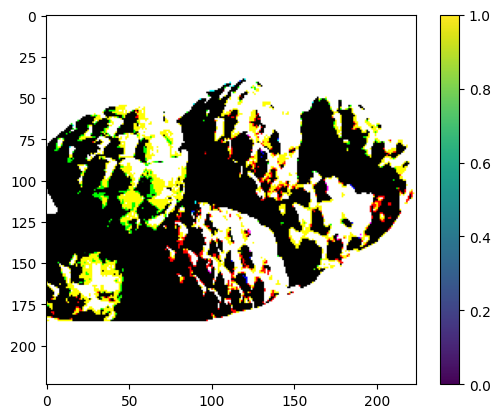

In [ ]:
x_train_img = np.clip(x_train, 0, 1)
plt.figure()
plt.imshow(x_train_img[1][:, :, ::-1])
plt.colorbar()
plt.grid(False)
plt.show();

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(45, 2)


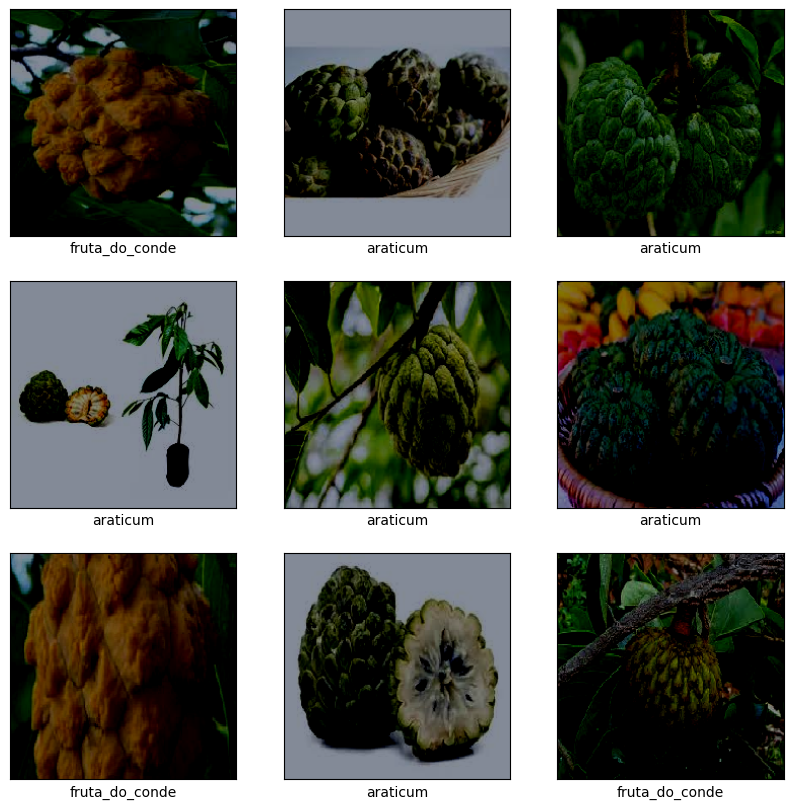

In [ ]:
# Plotando 9 imagens de treino
x_train_img = np.clip(x_train, 0, 1)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_img[i][:, :, ::-1])
    plt.xlabel(class_names[int(y_train[i][0])])
plt.show();

*Vamos* fazer um resumo do que temos.

In [ ]:
# summary
print(f"Carreganos {len(data)} imagens de {num_classes} categorias")
print(f"train / validation / test split: ({len(x_train)}, {len(x_val)}, {len(x_test)}")
print("formato de dados de treinamento: ", x_train.shape)
print("forma de rótulos de treinamento: ", y_train.shape)


Carreganos 300 imagens de 2 categorias
train / validation / test split: (210, 45, 45
formato de dados de treinamento:  (210, 224, 224, 3)
forma de rótulos de treinamento:  (210, 2)


Se tudo funcionou corretamente, você deveria ter carregado um monte de imagens e dividido-as em três conjuntos: `train`, `val` e `test`. A forma dos dados de treinamento deve ser (`n`, 224, 224, 3) onde `n` é o tamanho do seu conjunto de treinamento e os rótulos devem ser (`n`, `c`) onde `c` é o número de classes, nesse caso (2).

Observe que dividimos todos os dados em três subconjuntos - um conjunto de treinamento `train`, um conjunto de validação `val` e um conjunto de teste `test`. A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador utiliza o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajuste ao conjunto de treinamento. O conjunto `test` é sempre retirado do algoritmo de treinamento e só é usado no final para avaliar a precisão final do nosso modelo.

Vejamos rapidamente alguns exemplos de imagens de nosso conjunto de dados.

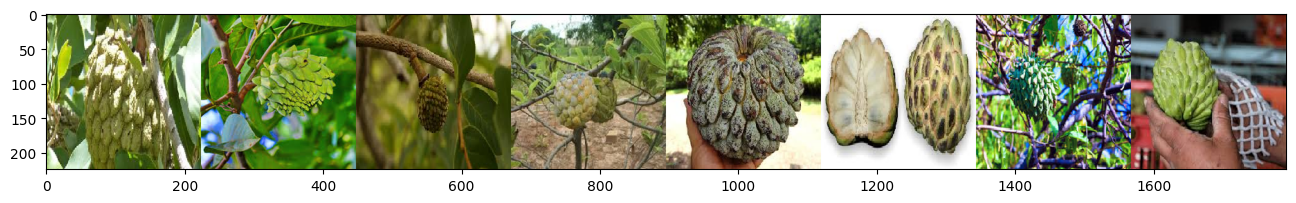

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image);

### Primeiro treinando uma rede neural do zero
---

Antes de fazer a aprendizagem por transferência, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma base para comparar posteriormente com nossa rede aprendida por transferência.

A rede que construiremos contém 4 camadas alternadas convolucionais e de max-pooling, seguidas por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada outro par conv/pooling . Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como sempre, perda categórica de entropia cruzada, e nosso algoritmo de aprendizagem será [AdaDelta](https://arxiv.org/abs/1212.5701). Várias coisas nesta rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, e portanto não é necessário gastar muito tempo tentando otimizar esta rede.

Ao compilar a rede, vamos executar `model.summary()` para obter um instantâneo de suas camadas.

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e tendências (os parâmetros). A maioria deles está levando a uma camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 30 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos representar graficamente a perda ao longo do tempo mais tarde.

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(x_val, y_val))


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.5078 - loss: 0.7039 - val_accuracy: 0.4444 - val_loss: 0.7391
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.5133 - loss: 0.7510 - val_accuracy: 0.4444 - val_loss: 0.6884
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.6314 - loss: 0.6792 - val_accuracy: 0.7556 - val_loss: 0.6698
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 11s/step - accuracy: 0.6886 - loss: 0.6666 - val_accuracy: 0.8000 - val_loss: 0.6412
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.7972 - loss: 0.6241 - val_accuracy: 0.8222 - val_loss: 0.5677
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.7721 - loss: 0.5524 - val_accuracy: 0.8000 - val_loss: 0.4667
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - accuracy: 0.7542 - loss: 0.5193 - val_accuracy: 0.7556 - val_loss: 0.4673
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.7570 - loss: 0.5226 - val_accuracy: 0.7556 - val_loss: 0.4704
Epoch 

In [ ]:
predictions = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step


### Imagem e gráfico de barras das predições do modelo:

O gráfico apresenta as categorias das imagens de teste em relação às suas predições pela rede. A barra azul indica a quantidade de classificações corretas, a barra cinza representa a proporção de predições em que a rede classificou parcialmente para classes erradas, enquanto a barra vermelha destaca as predições incorretas realizadas pelo modelo.


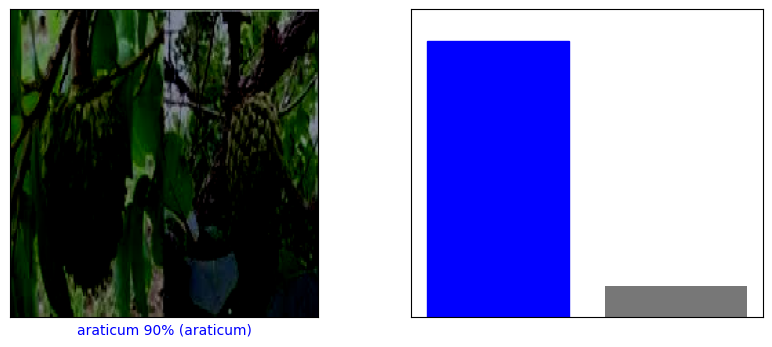

In [ ]:
i = 2

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)
plt.show();

Vamos representar graficamente a perda de validação e a precisão da validação ao longo do tempo.

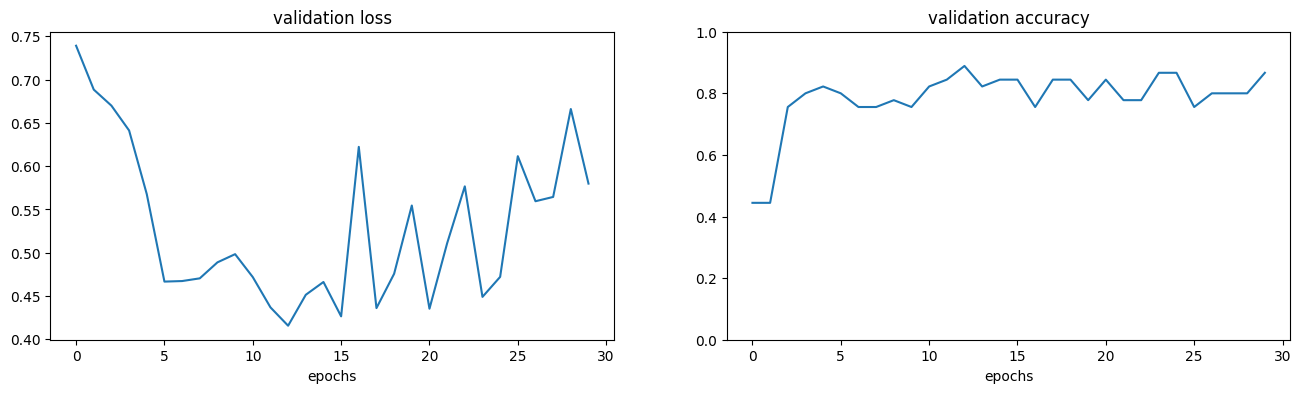

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Os gráficos mostram o comportamento da perda de validação e da precisão de validação ao longo de 30 épocas de treinamento. É possível observar que:

1. Perda de Validação:<BR>No gráfico à esquerda, observa-se que a perda de validação (validation loss) apresenta um padrão geral de redução até cerca da 16ª época, mas começa a aumentar gradativamente depois disso. Este aumento indica o início de overfitting, onde o modelo está se ajustando excessivamente aos dados de treinamento e, consequentemente, perde capacidade de generalização.

2. Precisão de Validação:<BR>
  O gráfico à direita mostra a precisão de validação (validation accuracy), que sobe consistentemente até aproximadamente a 10ª época e depois oscila em torno de um valor próximo de 80%. A estabilidade na precisão, mesmo com o aumento da perda, pode sugerir que o modelo ainda está capturando padrões úteis, mas há uma degradação gradual na qualidade da correspondência com os dados de validação.

### Análise
Com base nos dois gráficos, o melhor ponto de parada para o treinamento provavelmente seria entre as épocas 10 e 16. Após esse intervalo, o aumento da perda de validação combinado com a estabilização da precisão indica que o modelo não está mais melhorando de forma significativa.

A técnica de early stopping poderia ser utilizada, interrompendo o treinamento assim que a perda de validação parasse de diminuir de forma consistente.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5247550010681152
Test accuracy: 0.800000011920929


## Transfira o aprendizado começando com a rede existente


---


Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta é a primeira vez que carrega o VGG16, você precisará esperar um pouco até que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar novamente as camadas com o método `summary()`.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que VGG16 é _muito_ maior que a rede que construímos anteriormente. Ela contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que criamos acima. Como na nossa primeira rede, a maioria dos parâmetros são armazenados nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma [8,8% de taxa de erro entre os 5 primeiros](https://github.com/jcjohnson/cnn-benchmarks), o que significa que 91,2% das amostras de teste foram classificadas corretamente entre os 5 primeiros previsões para cada imagem. A precisão máxima - equivalente à métrica de precisão que estamos usando (que a previsão principal está correta) - é de 73%. Isso é especialmente impressionante porque não existem apenas 97, mas 1.000 classes, o que significa que suposições aleatórias nos dariam apenas 0,1% de precisão.

Para usar esta rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e em vez disso a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 2 neurônios no caso do conjunto de dados *Annonaceae*.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG desde sua camada de entrada até a penúltima camada e então trabalhar com ela, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe `Model` do keras para inicializar um novo modelo cuja camada de entrada é igual a VGG, mas cuja camada de saída é nossa nova camada softmax, chamada `new_classification_layer`.

Nota: embora pareça que estamos duplicando esta grande rede, internamente Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente esta rede, `model_new` no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador `trainable` em cada camada como falso (exceto nossa nova camada de classificação), garantimos que todos os pesos e tendências nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável *não* congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se parecer muito com o ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

Então vamos em frente e congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para uma comparação justa. Em seguida, executamos `summary` novamente para observar a arquitetura da rede.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1000 neurônios, foi substituída por um novo softmax de 2 neurônios. Além disso, ainda temos cerca de 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 8194 parâmetros treináveis.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, junto com o mesmo algoritmo de otimização. Também acompanhamos sua história à medida que avançamos.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=30,
                         validation_data=(x_val, y_val))


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 167s 81s/step - accuracy: 0.4769 - loss: 1.0384 - val_accuracy: 0.4444 - val_loss: 0.9958
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 199s 81s/step - accuracy: 0.5505 - loss: 0.8773 - val_accuracy: 0.5556 - val_loss: 1.0446
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 222s 99s/step - accuracy: 0.4937 - loss: 1.1761 - val_accuracy: 0.6444 - val_loss: 0.6447
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 200s 94s/step - accuracy: 0.5006 - loss: 0.7399 - val_accuracy: 0.4444 - val_loss: 0.9803
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 187s 81s/step - accuracy: 0.5011 - loss: 0.9527 - val_accuracy: 0.4889 - val_loss: 0.7330
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 221s 100s/step - accuracy: 0.5575 - loss: 0.7005 - val_accuracy: 0.6667 - val_loss: 0.5937
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 184s 83s/step - accuracy: 0.5708 - loss: 0.7455 - val_accuracy: 0.6444 - val_loss: 0.6132
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 175s 93s/step - accuracy: 0.5427 - loss: 0.7333 - val_accuracy: 0.6889 - val_loss

Vamos representar graficamente a perda e a precisão da validação novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em laranja.

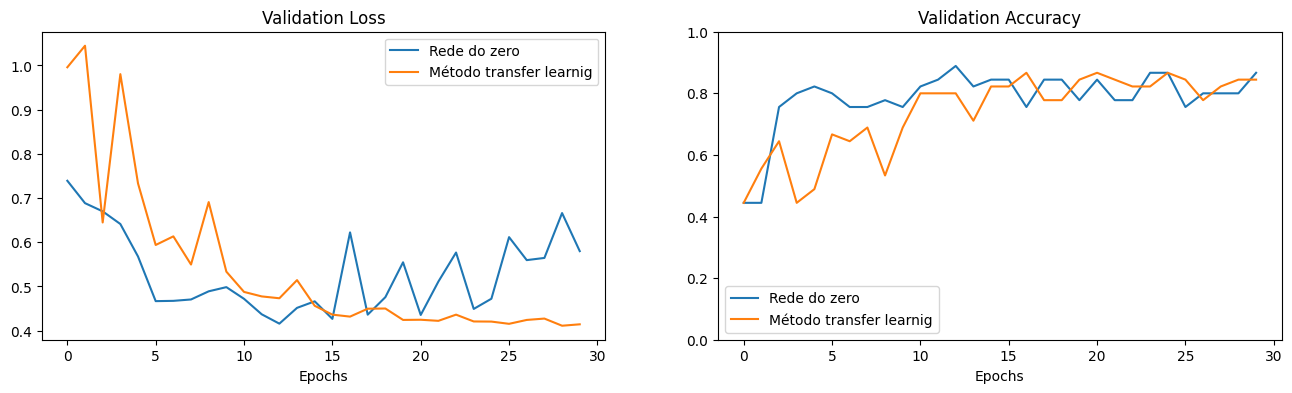

In [33]:
fig = plt.figure(figsize=(16, 4))

# Plot do validation loss
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Rede do zero")
ax.plot(history2.history["val_loss"], label="Método transfer learnig")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()  # Adiciona a legenda ao gráfico de perda

# Plot do validation accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Rede do zero")
ax2.plot(history2.history["val_accuracy"], label="Método transfer learnig")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()  # Adiciona a legenda ao gráfico de precisão

plt.show()


Observe que, embora o primeiro modelo (linha azul) tenha começado a mostrar sinais de estabilidade e uma leve oscilação na perda de validação após cerca de 15 épocas, o segundo modelo (linha laranja) apresenta um comportamento de aprendizagem mais consistente. O segundo modelo continuou a reduzir a perda de validação ao longo do tempo, indicando um ajuste mais eficaz aos dados, mesmo após o mesmo número de épocas.

A precisão de validação do segundo modelo também demonstra um aumento mais progressivo e consistente ao longo das épocas, estabilizando em torno de 80% de precisão top-1. Isso sugere que o segundo modelo ainda está em um estágio onde melhorias são possíveis com mais iterações, enquanto o primeiro modelo parece já ter atingido seu limite de desempenho.

### Comparação dos Modelos
- Primeiro Modelo, Rede do zero (Azul):

  - Mostra estabilidade na perda de validação após a 16ª época, com oscilações mínimas e sem sinais claros de sobreajuste.
  - A precisão de validação estabiliza em torno de 80%, mas o modelo parece já ter atingido seu limite de desempenho.
  -  ser considerado um modelo bem ajustado, mas com menos potencial de melhoria adicional.
- Segundo Modelo, *transfer-learning* (Laranja):

  - Continua a reduzir a perda de validação ao longo de todas as 30 épocas, indicando um ajuste mais eficaz e consistente.
  - A precisão também estabiliza em torno de 80%, mas o modelo apresenta maior progressão e menos oscilações, sugerindo que melhorias adicionais ainda são possíveis.
  - Mostra maior robustez e generalização ao longo do treinamento.

### Conclusão
Embora fosse possível melhorar o primeiro modelo ajustando a regularização (como dropout) ou utilizando outras estratégias de combate ao overfitting, dificilmente alcançaríamos os mesmos níveis de desempenho observados no segundo modelo. A precisão de validação (validation accuracy) de ambos os modelos parece estabilizar em torno de 80% após várias épocas. No entanto, como não há diferenças visíveis significativas entre as duas curvas na precisão, podemos concluir que não há ganho perceptível na precisão entre os dois modelos.

Apesar disso, a diferença está no comportamento das perdas (validation loss). O modelo da linha laranja, *transfer-learning*, reduz a perda de validação de forma mais consistente e progressiva, enquanto o modelo da linha azul, *Rede do zero*, estabiliza mais cedo, sugerindo que o segundo modelo, *transfer-learning*, pode ser mais robusto ou generalizável. Assim, o ganho entre os modelos não está na precisão em si, mas no potencial de generalização e estabilidade do modelo laranja *transfer-learning*. Explorá-lo com mais épocas ou ajustes adicionais poderia oferecer ainda melhores resultados.


Novamente, fazemos uma validação final no conjunto de teste.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5189951062202454
Test accuracy: 0.7333333492279053


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [ ]:
predictions_new = model_new.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step


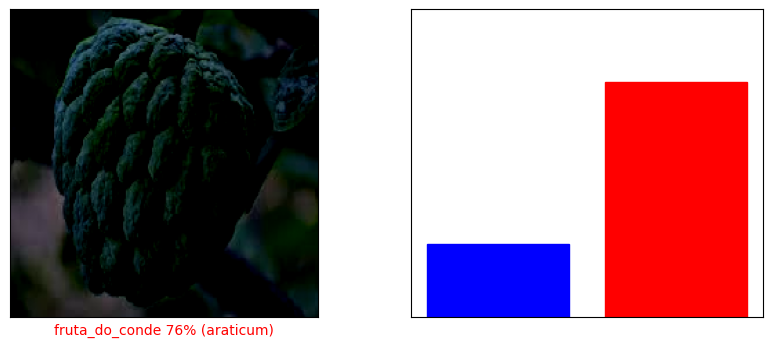

In [ ]:
i = 44

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions_new, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions_new,  y_test)
plt.show();

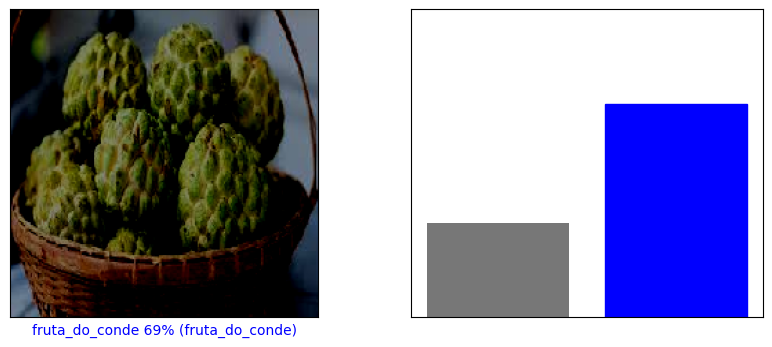

In [ ]:
i = 42

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions_new, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions_new,  y_test)
plt.show();

Segue uma análise e estratégias para melhorar ainda mais os resultados:

### Estratégias de Melhoria
1. Aumento de dados (Data Augmentation)<BR>
Aumentar o tamanho e a diversidade do conjunto de treinamento pode reduzir o overfitting e melhorar a capacidade de generalização. Isso pode incluir:

  - Transformações geométricas: rotações, espelhamentos, cortes e escalas.
  - Alterações de cor: mudanças no brilho, contraste e saturação.
  - Distorções: aplicar distorções leves nas imagens para simular variações reais.
  O uso de bibliotecas como ImageDataGenerator do Keras ou Albumentations pode facilitar esse processo.

2. Regularização e Dropout<BR>
Adicionar dropout (por exemplo, 0.2 ou 0.5) em camadas densas ou convolucionais pode reduzir o risco de overfitting, especialmente no modelo treinado do zero.
3. Explorar Otimizadores Diferentes<BR>
Ajustar a taxa de aprendizado com agendamento (learning rate scheduler) também pode melhorar a convergência.

4. Treinamento por Mais Tempo<BR>
Para o modelo transfer-learning o treinamento por mais épocas pode trazer ganhos adicionais. Usar parada antecipada (early stopping) com paciência maior, para evitar parar cedo demais, é uma boa prática.

5. Ajuste Fino dos Hiperparâmetros<BR>
Realizar uma busca sistemática (grid search ou random search) para ajustar:

6. Validação Cruzada (Cross-Validation)<BR>
Para avaliar melhor o desempenho e evitar que o modelo se ajuste a um único conjunto de validação, utilizar validação cruzada (k-fold) pode oferecer uma estimativa mais robusta da performance.

## Considerações Finais
Com base nas estratégias acima, recomendamos começar pelo aumento de dados e regularização, que são eficazes para reduzir o overfitting. A seguir, explorar otimizadores e realizar transferência de aprendizado pode oferecer ganhos significativos.

Essas técnicas, aliadas a mais treinamento e ajustes de hiperparâmetros, podem levar ambos os modelos a alcançar maior precisão e melhor generalização no conjunto de validação.

---

Um exemplo mais avançado de aprendizagem por transferência em Keras, envolvendo aumento para um pequeno conjunto de dados de 2 classes, pode ser encontrado no [blog Keras](https://blog.keras.io/building-powerful-image-classification-models-usando-muito-pouco-dados.html).